In [1]:
import numpy as np
import math

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
tfd = tfp.distributions		# TensorFlow Probability distributions
tfpl = tfp.layers			# TensorFlow Probability layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import losses
from tensorflow.keras import optimizers

import pandas as pd
import seaborn as sns


# Make Data

In [2]:
def makeData():
  #MAKE DATA
  # From parbola/main.py

  # ------------------------------------------------------------------------------
  # General setup
  # ------------------------------------------------------------------------------
  # Set seeds for reproducibility
  np.random.seed(0)
  tf.random.set_seed(0)

  # Function coefficients (f = f_a*x^2 + f_b*y^2)
  f_a = 1.0
  f_b = 1.0

  # ------------------------------------------------------------------------------
  # Data preparation
  # ------------------------------------------------------------------------------
  # Labeled data within interpolation region 
  # \Omega_{int} = [-1,1]^2
  N_f = 2500
  X_f = np.zeros((N_f, 2), dtype = np.float32)
  X_f[:, 0] = np.random.uniform(-1.0, 1.0, N_f)	# x in interpolation region
  X_f[:, 1] = np.random.uniform(-1.0, 1.0, N_f)	# y in interpolation region
  f = f_a*np.square(X_f[:, 0:1]) + f_b*np.square(X_f[:, 1:2])	# f_a*x^2 + f_b*y^2

  # Regularization collocation points within extrapolation region 
  # \Omega_{ext} = [-2,2]^2/\Omega_{int}
  N_df = 7500
  X_df = np.zeros((N_df, 2), dtype = np.float32)
  # Create random points in extrapolation region
  added = 0
  while (added < N_df):
    x = np.random.uniform(-2.0, 2.0, 1);
    y = np.random.uniform(-2.0, 2.0, 1);
    # Exclude points that fall into the interpolation region
    if (np.abs(x) > 1.0 or np.abs(y) > 1.0):
      X_df[added, 0] = x
      X_df[added, 1] = y
      added = added + 1

  # Scatter plot of label locations and collocation points
  fig = plt.figure();
  ax = fig.add_subplot(111)
  ax.scatter(X_f[:,0], X_f[:,1], s=2, c='green')
  ax.scatter(X_df[:,0], X_df[:,1], s=2, c='red')
  plt.xlim([-2.0, 2.0])
  plt.ylim([-2.0, 2.0])
  plt.tight_layout(pad=0.5)
  ax.xaxis.set_tick_params(labelsize=12)
  ax.yaxis.set_tick_params(labelsize=12)
  # plt.savefig('figs/samples.png')
  plt.close(fig);

  # Create TensorFlow dataset for passing to 'fit' function (below)
  dataset = tf.data.Dataset.from_tensors((X_f, f, X_df))

  dataset_list = []
  dataset_list.append(tf.convert_to_tensor(X_f, dtype=tf.float32))
  dataset_list.append(tf.convert_to_tensor(f, dtype=tf.float32))
  dataset_list.append(tf.convert_to_tensor(X_df, dtype=tf.float32))

  return dataset_list

In [3]:
X, f, Xextrap = makeData()

# Bayesian Neural Networks

In [4]:
# BAYESIAN NEURAL NETWORK CLASS
# SECTION 2.5 

class PhysicsInformedNN(keras.models.Model):

	#
	# Custom loss for function value
	# 
	def loss_function_f(self, f, f_pred):
		sq_diff = tf.math.squared_difference(f, f_pred)  
		loss_value = tf.math.reduce_sum(sq_diff)
		return loss_value			 
	# def loss_function_f
	
	#
	# Called from outside as a convenient way (albeit slightly risky)
	# to specify the mini-batch size
	#
	def set_batch_size(self, batch_size):
		self.batch_size = batch_size

	#
	# Create mini batches
	#
	@tf.function
	def create_mini_batches(self, dataset):
		# Batch size should by user using the 'set_batch_size' function
		batch_size = self.batch_size

		X_f, f, X_df = dataset
		
		# Number of batches determined based on largest number of 
		# training samples (sizes of X_f and X_df may differ)
		m_f = X_f.shape[0]
		m_df = X_df.shape[0]
		m = np.max([m_f, m_df])
		num_batches = math.floor(m/batch_size)

		# Mini-batch sizes
		bs_f = math.floor(m_f/num_batches)
		bs_df = math.floor(m_df/num_batches)
		
		# Create mini-batches based on random selection
		perm_idx_f = np.random.permutation(m_f)
		perm_idx_df = np.random.permutation(m_df)
		batches = []

		for i in range(num_batches):
			idx0 = bs_f*i
			idx1 = bs_f*(i + 1)
			indices = perm_idx_f[idx0:idx1]
			X_f_b = tf.gather(X_f, indices, axis = 0)
			f_b = tf.gather(f, indices, axis = 0)
			
			idx0 = bs_df*i
			idx1 = bs_df*(i + 1)
			indices = perm_idx_df[idx0:idx1]
			X_df_b = tf.gather(X_df, indices, axis = 0)
			
			batch = (X_f_b, f_b, X_df_b)
			batches.append(batch)
		
		if (num_batches*bs_f < m_f) or (num_batches*bs_df < m_df):
			idx0 = bs_f*num_batches
			idx1 = m_f
			indices = perm_idx_f[idx0:idx1]
			X_f_b = tf.gather(X_f, indices, axis = 0)
			f_b = tf.gather(f, indices, axis = 0)

			idx0 = bs_df*num_batches
			idx1 = m_df
			indices = perm_idx_df[idx0:idx1]
			X_df_b = tf.gather(X_df, indices, axis = 0)
			
			batch = (X_f_b, f_b, X_df_b)
			batches.append(batch)
		
		return batches
	# def create_mini_batches	
	
	#
	# Redefine train_step used for optimizing the neural network parameters
	# This function implements one epoch (one pass over entire dataset)
	#
	@tf.function
	def train_step(self, dataset):
		
		# Retrieve size of entire dataset (X_f, f, X_df)
		m_f = dataset[0].shape[0]	# dataset[0] = X_f
		
		mini_batches = self.create_mini_batches(dataset)	
		
		# Keep track of total loss value for this epoch
		loss_value_f = 0.0
		loss_value_df = 0.0
		
		# Loop over all mini-batches
		for batch in mini_batches:
			
			L_f, L_df = self.process_one_batch(batch)
						
			# Increment total loss value by mini-batch-wise contribution
			loss_value_f += L_f
			loss_value_df += L_df

		# end for loop on mini batches
		
		# KB: This is the loss function including regularization
		loss_value = loss_value_f/m_f + self._r*loss_value_df

		# Update loss and return value
		return {'loss': loss_value}
		#return loss_value
		
	# def train_step
	
	#
	# Compute loss function terms for one batch (just summation, no mean
	@tf.function
	def process_one_batch(self, batch):
		X_f, f, X_df = batch
		
		# Compute regularization term
		with tf.GradientTape(persistent=False) as tape:
			
			# Forward run and compute base loss function
			f_pred = self.call(X_f)
			Lf = self.loss_function_f(f, f_pred)

			# Regularization
			with tf.GradientTape(persistent=True) as tape_reg:
				tape_reg.watch(X_df)
				# KB: Below is the gradient computation
				# Hack to enable gradient computation w.r.t. columns x and y
				x, y = tf.unstack(X_df, axis=1)
				X_df = tf.stack([x,y], axis=1)
				df_pred = self.call(X_df)
				dfdx = tape_reg.gradient(df_pred, x)
				dfdy = tape_reg.gradient(df_pred, y)
				dfdxx = tape_reg.gradient(dfdx, x)
				dfdyy = tape_reg.gradient(dfdy, y)
				dfdxy = tape_reg.gradient(dfdx, y)
			
			# KB: THIS IS THE REGULARIZER
			Lreg = tf.math.reduce_variance(dfdxx) + \
				   tf.math.reduce_variance(dfdyy) + \
				   2*tf.math.reduce_variance(dfdxy)
			
			# Total loss function is a weighted sum
			r = self._r
			L = Lf + r*Lreg
		
		# Compute gradient of total loss w.r.t. trainable variables
		trainable_vars = self.trainable_variables
		dLdtheta = tape.gradient(L, trainable_vars)
	
		# Update network parameters
		self.optimizer.apply_gradients(zip(dLdtheta, trainable_vars))

		return Lf, Lreg
		
	# def process_one_batch
	
	#
	# Custom optimize function
	#
	def optimize(self, 
				 dataset, 
				 num_its,
				 regularization_schedule):
		self.regularization_schedule = regularization_schedule
		loss_history = []
		for it in range(num_its):
			self._r = self.get_regularization_penalty_factor(it)
			loss = self.train_step(dataset)
			tf.print("Epoch: ", it, ". Loss: ", loss, "R: ", self._r);
			loss_history.append(loss)
		history = tf.keras.callbacks.History()
		history.history = {"loss": loss_history}
		return history
	# def optimize

	def get_regularization_penalty_factor(self, it):
		it0 = self.regularization_schedule["e0"]
		r0 = self.regularization_schedule["r0"]
		it1 = self.regularization_schedule["e1"]
		r1 = self.regularization_schedule["r1"]
		if it < it0:
			return r0
		elif (it >= it0) and (it <= it1):
			return r0 + (r1 - r0)*(it - it0)/(it1 - it0)
		else:
			return r1;
	# def get_regularization_penalty_factor

# class PhysicsInformedNN



In [5]:
def create_bnn_model(x, y, x_df,
							   	  num_epochs,
							   	  learning_rate,
                    layer_widths,
							   	  verbose=0):
  
    # Prior (non-trainable) distribution					
    def prior_fn(kernel_size, bias_size, dtype = None):
      n = kernel_size + bias_size;
      prior = Sequential([
        tfpl.DistributionLambda(lambda t:
        tfd.MultivariateNormalDiag(loc = tf.zeros(n), 
                      scale_diag = tf.ones(n)))
      ])
      return prior
      # def prior_fn()

    def posterior_fn(kernel_size, bias_size, dtype = None):
      #print(kernel_size, bias_size)
      n = kernel_size + bias_size
      posterior = Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), 
                  dtype=dtype),
        tfpl.IndependentNormal(n)
      ])
      return posterior
      # def posterior_fn()
  
    inputs = tf.keras.Input(shape=2)
    #features = keras.layers.concatenate(list(inputs))
    #features = layers.BatchNormalization()(features)

    features = inputs

    hidden_units = len(layer_widths) - 2

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in layer_widths:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior_fn,
            make_posterior_fn=posterior_fn,
            kl_weight=1 / x.shape[0],
            activation="sigmoid",
            use_bias = True
        )(features)

    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)
    model = PhysicsInformedNN(inputs=inputs, outputs=outputs)
    return model





In [6]:
opt_step = 0.01		# gradient descent step
opt_batch_size = 256	# batch size
opt_num_its = 2000		# number of iterations
regularization_schedule = {"e0": 0,			 # starting epoch for regularization
						   "r0": 1.0,		 # starting penalty factor
						   "e1": opt_num_its,# ending epoch for regularization
						   "r1": 1.0}		 # ending penalty factor


In [7]:
model = create_bnn_model(X, 
                         f, 
                         Xextrap, 
                         num_epochs = opt_num_its, 
                         learning_rate = opt_step, 
                         layer_widths = [20, 20])
model.summary()

Model: "physics_informed_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_variational (DenseVar  (None, 20)               120       
 iational)                                                       
                                                                 
 dense_variational_1 (DenseV  (None, 20)               840       
 ariational)                                                     
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [8]:
dataset_list = []
dataset_list.append(tf.convert_to_tensor(X, dtype=tf.float32))
dataset_list.append(tf.convert_to_tensor(f, dtype=tf.float32))
dataset_list.append(tf.convert_to_tensor(Xextrap, dtype=tf.float32))


In [9]:

model.set_batch_size(opt_batch_size)

optimizer = optimizers.Adam(learning_rate = opt_step)
model.compile(optimizer = optimizer)
tic = time.time()
'''
dataset = tf.data.Dataset.from_tensors((X, f, Xextrap))

fit_process = model.fit(dataset, 
		  				epochs=opt_num_its, 
					    verbose=2)
'''
fit_process = model.optimize(dataset_list, 
							 opt_num_its,
							 regularization_schedule)
               
toc = time.time()
print("Training time: {:.2F} s\n".format(toc - tic))

Epoch:  0 . Loss:  {'loss': 0.423456669} R:  1.0
Epoch:  1 . Loss:  {'loss': 0.311832845} R:  1.0
Epoch:  2 . Loss:  {'loss': 0.243672848} R:  1.0
Epoch:  3 . Loss:  {'loss': 0.339879215} R:  1.0
Epoch:  4 . Loss:  {'loss': 0.229436666} R:  1.0
Epoch:  5 . Loss:  {'loss': 0.211567476} R:  1.0
Epoch:  6 . Loss:  {'loss': 0.228853166} R:  1.0
Epoch:  7 . Loss:  {'loss': 0.611345768} R:  1.0
Epoch:  8 . Loss:  {'loss': 0.313350737} R:  1.0
Epoch:  9 . Loss:  {'loss': 0.245458305} R:  1.0
Epoch:  10 . Loss:  {'loss': 0.44062376} R:  1.0
Epoch:  11 . Loss:  {'loss': 0.348730177} R:  1.0
Epoch:  12 . Loss:  {'loss': 0.249498188} R:  1.0
Epoch:  13 . Loss:  {'loss': 0.28532064} R:  1.0
Epoch:  14 . Loss:  {'loss': 0.344224334} R:  1.0
Epoch:  15 . Loss:  {'loss': 0.245703965} R:  1.0
Epoch:  16 . Loss:  {'loss': 0.212035656} R:  1.0
Epoch:  17 . Loss:  {'loss': 0.336725056} R:  1.0
Epoch:  18 . Loss:  {'loss': 0.296580762} R:  1.0
Epoch:  19 . Loss:  {'loss': 0.234322816} R:  1.0
Epoch:  20 .

In [60]:
model.predict(X)

<tf.Tensor: shape=(2500, 2), dtype=float32, numpy=
array([[ 0.09762701,  0.70264685],
       [ 0.43037874, -0.5288656 ],
       [ 0.20552675,  0.51636696],
       ...,
       [ 0.44866195, -0.6052235 ],
       [-0.61685795, -0.20262556],
       [ 0.32434848,  0.9171862 ]], dtype=float32)>

In [11]:
model_prior=model.layers[1]._prior(np.array([[0]]))
print('Prior mean :     ', model_prior.mean().numpy())
print('Prior variance:  ', model_prior.variance().numpy())

model_posterior=model.layers[1]._posterior(np.array([[0]]))
print('Posterior mean :     ', model_posterior.mean().numpy())
print('Posterior variance:  ', model_posterior.variance().numpy())

Prior mean :      [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Prior variance:   [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Posterior mean :      [-1.5970863   0.18594687  0.15164845  1.607784    1.9949824   0.7507656
 -1.729197   -1.3595874  -1.5034552   0.28656355 -0.10967198 -1.8239594
  2.5740116  -0.31808475  0.13484494 -0.8800398  -0.39502183 -0.1443172
 -1.7523214   1.5706054   0.63256925  1.3523747  -1.5360719  -0.4524109
  0.3943866   1.7041829  -1.0312983   0.03780212 -0.544068    1.4701917
  0.21748509  0.563291    0.6148198   2.1358557   1.5438145  -1.8750348
  2.3566608  -0.16006173  0.8481655  -1.1418152  -2.3185215  -4.479224
 -3.630038   -4.5260277   1.8085988  -2.1823156  -1.8650389  -4.2309422

In [12]:
import pandas as pd

In [13]:
N = 30

f_interp = np.zeros((len(X), N))
for i in range(N):
  f_interp[:,i] = model.predict(X).flatten()

f_interp = pd.DataFrame(f_interp)

In [14]:
f_interp

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.494688,0.498654,0.495721,0.494355,0.496382,0.495194,0.492867,0.495848,0.494444,0.495356,...,0.494785,0.496684,0.498007,0.493823,0.496084,0.497630,0.496019,0.497142,0.497764,0.489338
1,0.458016,0.460999,0.459311,0.456973,0.455876,0.460525,0.457795,0.461362,0.457934,0.459813,...,0.457497,0.461266,0.461774,0.459157,0.462350,0.463437,0.459776,0.462493,0.462546,0.455692
2,0.300952,0.303672,0.301608,0.299860,0.301369,0.301353,0.298832,0.302380,0.299943,0.301698,...,0.301068,0.303505,0.303874,0.299873,0.302297,0.303506,0.301676,0.303581,0.304094,0.295897
3,0.074561,0.076397,0.075722,0.073663,0.073728,0.075852,0.072915,0.076932,0.072597,0.075628,...,0.075215,0.078115,0.077405,0.073897,0.076477,0.077753,0.074813,0.077439,0.077726,0.070307
4,0.839596,0.846454,0.842429,0.841531,0.843491,0.840867,0.839130,0.840665,0.840966,0.840470,...,0.840167,0.840873,0.844256,0.839642,0.841851,0.844173,0.842759,0.842200,0.842922,0.834591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.315780,0.316686,0.318631,0.315271,0.321625,0.317811,0.318412,0.317549,0.320379,0.315368,...,0.317390,0.318886,0.320457,0.318005,0.316664,0.319705,0.314771,0.319797,0.319823,0.310453
2496,0.439659,0.439160,0.439684,0.434857,0.436385,0.437081,0.443114,0.441768,0.441989,0.439523,...,0.438223,0.439367,0.434474,0.437635,0.439065,0.436693,0.440449,0.440209,0.439657,0.441120
2497,0.563943,0.563223,0.563429,0.558909,0.560674,0.561214,0.567598,0.566060,0.566408,0.564006,...,0.562539,0.563871,0.558314,0.561663,0.562870,0.560952,0.565011,0.564433,0.563944,0.565238
2498,0.420880,0.419493,0.423764,0.414304,0.415061,0.418575,0.422366,0.424107,0.420003,0.419408,...,0.418968,0.419902,0.415722,0.416786,0.417258,0.415706,0.419392,0.422345,0.418111,0.422758


In [32]:
InterpSummary = pd.DataFrame()
InterpSummary['x'] = X[:,0]
InterpSummary['y'] = X[:,1]
InterpSummary['mean'] = f_interp.mean(axis = 1) 
InterpSummary['std'] = f_interp.std(axis = 1) 
InterpSummary['true_mean'] = np.square(X[:,0]) + np.square(X[:,1])
InterpSummary['diff_mean'] = f_interp.mean(axis = 1) - InterpSummary['true_mean']



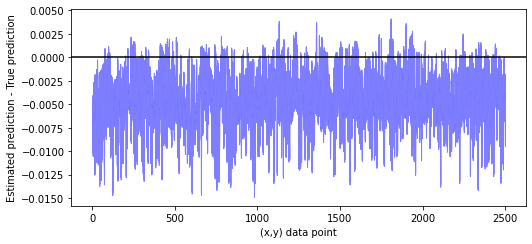

In [16]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

x = np.arange(0, 2500)
y = InterpSummary['diff_mean']

# Define the confidence interval
ci = 1.96 * np.std(y) / np.sqrt(len(y))

#plt.plot(x, y, color='grey', lw=1, alpha = 0.5)

plt.fill_between(x, (y-ci), (y+ci), color='blue', alpha=0.5)
plt.axhline(y = 0, color = 'black')
plt.xlabel("(x,y) data point")
plt.ylabel("Estimated prediction - True prediction")

plt.show()

In [17]:
N = 30

f_extrap = np.zeros((len(Xextrap), N))
for i in range(N):
  f_extrap[:,i] = model.predict(Xextrap).flatten()

f_extrap = pd.DataFrame(f_extrap)

In [33]:
ExtrapSummary = pd.DataFrame()
ExtrapSummary['x'] = Xextrap[:,0]
ExtrapSummary['y'] = Xextrap[:,1]
ExtrapSummary['mean'] = f_extrap.mean(axis = 1) 
ExtrapSummary['std'] = f_extrap.std(axis = 1) 
ExtrapSummary['true_mean'] = np.square(Xextrap[:,0]) + np.square(Xextrap[:,1])
ExtrapSummary['diff_mean'] = f_extrap.mean(axis = 1) - ExtrapSummary['true_mean']



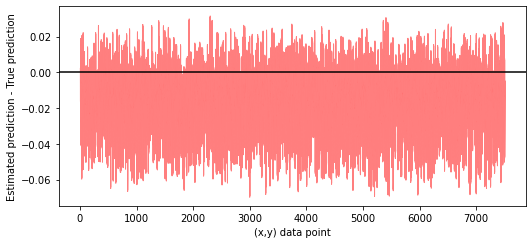

In [19]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

x = np.arange(0, 7500)
y = ExtrapSummary['diff_mean']

# Define the confidence interval
ci = 1.96 * np.std(y) / np.sqrt(len(y))

#plt.plot(x, y, color='grey', lw=1, alpha = 0.5)

plt.fill_between(x, (y-ci), (y+ci), color='red', alpha=0.5)
plt.axhline(y = 0, color = 'black')
plt.xlabel("(x,y) data point")
plt.ylabel("Estimated prediction - True prediction")

plt.show()

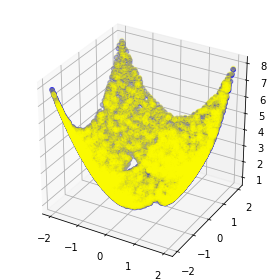

In [20]:
fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(Xextrap[:,0],Xextrap[:,1], ExtrapSummary['mean'], color = 'blue') # plot the point (2,3,4) on the figure
ax.scatter(Xextrap[:,0],Xextrap[:,1], np.square(Xextrap[:,0]) + np.square(Xextrap[:,1]), color = 'yellow', alpha = 0.2) # plot the point (2,3,4) on the figure

plt.show()

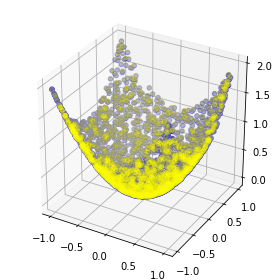

In [21]:
fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:,0],X[:,1], InterpSummary['mean'], color = 'blue') # plot the point (2,3,4) on the figure
ax.scatter(X[:,0],X[:,1], np.square(X[:,0]) + np.square(X[:,1]), color = 'yellow', alpha = 0.2) # plot the point (2,3,4) on the figure

plt.show()

In [49]:
# MAKE A HEATMAP
# set seaborn style
Xmesh, Ymesh = np.meshgrid(X[:,0], X[:,1])

sns.set_style("white")
pivotted = InterpSummary.pivot('x','y','mean')
plt.show()



array([[ 0.70264685,  0.70264685,  0.70264685, ...,  0.70264685,
         0.70264685,  0.70264685],
       [-0.5288656 , -0.5288656 , -0.5288656 , ..., -0.5288656 ,
        -0.5288656 , -0.5288656 ],
       [ 0.51636696,  0.51636696,  0.51636696, ...,  0.51636696,
         0.51636696,  0.51636696],
       ...,
       [-0.6052235 , -0.6052235 , -0.6052235 , ..., -0.6052235 ,
        -0.6052235 , -0.6052235 ],
       [-0.20262556, -0.20262556, -0.20262556, ..., -0.20262556,
        -0.20262556, -0.20262556],
       [ 0.9171862 ,  0.9171862 ,  0.9171862 , ...,  0.9171862 ,
         0.9171862 ,  0.9171862 ]], dtype=float32)

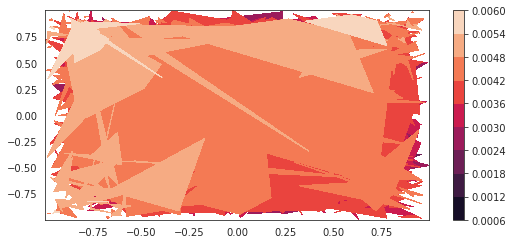

In [55]:
InterpHeat = pd.DataFrame()
InterpHeat['x'] = InterpSummary['x']; InterpHeat['y'] = InterpSummary['y']; InterpHeat['mean'] = InterpSummary['mean']


plt.contourf(InterpSummary['x'].values.reshape(50,50),InterpSummary['y'].values.reshape(50,50), InterpSummary['std'].values.reshape(50,50)) #reshape Z too!
plt.colorbar()

In [57]:

ExtrapSummary

,x,y,mean,std,true_mean,diff_mean
0,-1.725602,-0.589890,3.328020,0.007676,3.325671,0.002349
1,-1.071216,1.051709,2.237625,0.005669,2.253596,-0.015971
2,-1.553487,-1.425276,4.455332,0.009153,4.444733,0.010599
3,1.385220,1.165135,3.250217,0.007169,3.276372,-0.026155
4,0.038248,1.552132,2.383090,0.005911,2.410578,-0.027488
...,...,...,...,...,...,...
7495,-1.837323,1.760924,6.429294,0.016754,6.476608,-0.047315
7496,1.336053,1.535654,4.106804,0.009174,4.143270,-0.036466
7497,0.528458,1.446834,2.348063,0.006421,2.372597,-0.024534
7498,1.786227,-0.276135,3.252823,0.007258,3.266858,-0.014036


In [78]:
def make_heat_map():
  # For parabolic case
  X = np.linspace(-1,1,2500)
  Y = np.linspace(-1,1,2500)
  X_pr = np.zeros((2500, 2))
  X_pr[:,0] = X; X_pr[:,1] = Y
  X_pass = tf.convert_to_tensor(X_pr)
  f_true = np.square(X) + np.square(Y)

  N = 30

  f_pred = np.zeros((2500, N))
  for i in range(N):
    f_pred[:,i] = model.predict(X_pass).flatten()

  f_pred = pd.DataFrame(f_pred)

  f_pred_std = f_pred.std(axis = 1) 

  plt.contourf(X.reshape(50,50),Y.reshape(50,50), f_pred_std.values.reshape(50,50)) #reshape Z too!
  plt.colorbar()
    

In [112]:
X, Y = np.meshgrid( np.linspace(-1,1,2500), np.linspace(-1,1,2500))
print(pd.DataFrame(Y))
print(Y.reshape(-1,1))
X.reshape(-1,1)
Y.reshape(-1,1)

[[-1.]
 [-1.]
 [-1.]
 ...
 [ 1.]
 [ 1.]
 [ 1.]]


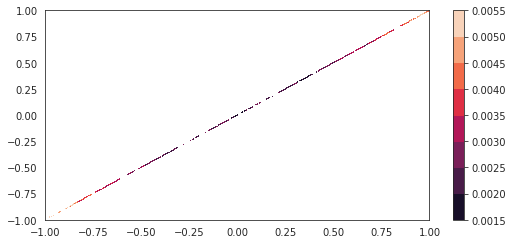

In [79]:
make_heat_map()
# Issue is data collection here - need to extend data
